# Analysing Effect Sizes 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, skewnorm
%matplotlib inline

In [2]:
plt.style.use('fivethirtyeight')

Complete list of effect sizes and security ratings from [EEF funded projects](https://educationendowmentfoundation.org.uk/our-work/projects/)

In [3]:
ess = np.array([0,-2,4,-1,2,3,-1,2,3,-1,-1,0,0,0,1,3,2,1,1,0,1,
                3,1,-1,3,1,-1,1,-1,1,2,5,2,5,3,1,4,1,-1,2,-1,2,6,
                -1,3,3,1,-2,-2,9,1,3,-1,1,1,3,1,1,-2,-1,-1])
sec = np.array([4,1,4,2,4,1,3,2,3,4,3,4,4,1,3,4,3,4,3,5,3,3,0,1,
                3,2,3,3,3,4,3,0,2,3,5,1,4,4,0,4,1,3,2,4,4,0,4,1,3,
                2,3,3,3,2,0,3,4,3,1,3,3])

Perturbed funnel plot of results. X-axis is "security rating". I added a perturbation so that points didn't sit on top of each other - I think it makes it easier to see where the points are dense.

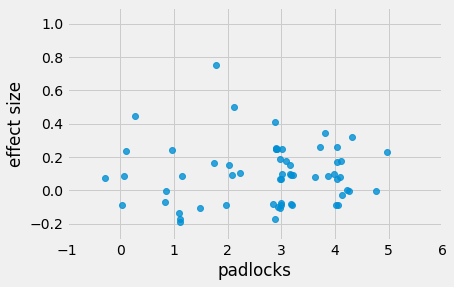

In [5]:
plt.plot(sec+np.random.randn(len(ess))/6,ess/12+np.random.randn(len(ess))/(6*12),'o',alpha=0.8)
plt.xlim(-1,6)
plt.ylim(-0.3,1.1)
plt.ylabel('effect size')
plt.xlabel('padlocks')
plt.show()

I haven't done any proper tests, but this doesn't look particularly biased to me. The two large effect sizes at 2 padlocks are - well, there's only two of them.

### Histogram of effect sizes, mean and standard deviation.

I eyeballed a skew-norm fit to get a distribution I can sample from. This is for some pretty rough calculation; the weight of the tail is probably important, but the scale factor is fine being somewhere in the general ballpark

Note that these bins are kind of selected to produce a smooth looking histogram



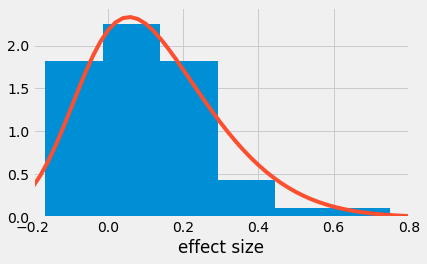

In [11]:
xs = np.arange(-0.3,0.9,0.02)
plt.hist(ess/12,bins=6,normed=True)
plt.plot(xs,skewnorm.pdf(xs,2.5,-0.08,0.27))
plt.xlim([-0.2,0.8])
plt.xlabel('effect size')
plt.gcf().subplots_adjust(bottom=0.15)
plt.show()

In [6]:
print("mean = {:.3f} std = {:.3f}".format(np.average(ess/12),np.std(ess/12)))

mean = 0.098 std = 0.178


### Simulation

Start with $n$ possible interventions. If we call the set of all interventions in the 95th percentile $x$, how long (in teacher-years) will it take us until our estimate $\hat{x}$ contains 80% of the members of the true $x$?

Parameters:
Individual student variation in growth scores

$\sigma_\epsilon = 0.6$ (Kaine and Staiger + EEF)

Classwide random variation in growth scores

$\sigma_\theta = 0.2$ (Chetty + Kaine and Staiger + EEF)

Average class size: 20 students (bum-pluck)

I am going to take the average effect of all the programs to be the "opportunity cost" of imposing new programs on all schools. See section 1 [here](https://morningpigeon.wordpress.com/2017/06/16/a-paradox/)

In [905]:
N = 100
progs = skewnorm.rvs(2.5,-0.08,0.27,N)
progs.sort()

What could we gain if we could make everyone adopt the top 20/10/5% of things to do?

TODO: Estimate number of programs and number of adoptable programs in a more principled manner

In [753]:
top20 = np.average(progs[-int(0.2*N):])-np.average(progs)
top10 = np.average(progs[-int(0.1*N):])-np.average(progs)
top5 = np.average(progs[-int(0.05*N):])-np.average(progs)
top1 = np.average(progs[-int(0.01*N):])-np.average(progs)
toptop = progs[-1] - np.average(progs)

print("Top 20%: {:.2f}, top 10%: {:.2f}, top 5%: {:.2f}, top 1% {:.2f}, top {:.2f}".format(top20, 
                                                                                           top10, 
                                                                                           top5, 
                                                                                           top1,
                                                                                           toptop))

Top 20%: 0.26, top 10%: 0.34, top 5%: 0.41, top 1% 0.51, top 0.51


In [871]:
# Generic Normal bayes update
def update(mp, sp, r, ss):
    mn = (r*sp**2+mp*ss**2)/(ss**2+sp**2)
    sn2 = (ss**2*sp**2)/(ss**2+sp**2)
    #print(np.array([mp,r,mn]).T)
    return mn, np.sqrt(sn2)

# Standard deviation of the results of one class - see assumptions above
sig = np.sqrt(0.2**2 + 0.25/20)

Initial prior on all programs will be similar to weak prior used above: $\mu = 0$, $\sigma=0.5$

Add negligible noise as a hack to permit initial calculation of the top 20

In [906]:
dists = np.array([[i, 0 + np.random.random()*0.001, 0.5] for i in range(N)])

Initial proportion of actual top 5% in apparent top 5% of dists

In [588]:
def prop_percentile(dists,percentile = 0.95):
    s = sorted(dists, key= lambda x: x[1])
    i = int(percentile*len(dists))
    p = s[i][1]
    ids = [j[0] for j in dists if j[1] >= p and j[0] >= int(percentile*len(dists))]
    return len(ids)/int((1-percentile)*len(dists))

print("{:.4f}".format(prop_percentile(dists,percentile=0.95)))

0.0000


In [927]:
# Run n trials using uniform sampling

def run_trials(dists,n,s=sig,mu=[]):
    d = np.copy(dists)
    samp = np.random.choice(len(dists),
                            n,
                            replace=False)
    if not len(mu):
        mu = np.zeros(n)
    r = np.random.normal(progs[samp]+mu[:len(samp)],sig)
    d[samp,1], d[samp,2] = update(dists[samp,1], dists[samp,2], r ,s)
    return d, np.average(progs[samp])

# Run n trials using kinda-thompson sampling

def run_trials_ts(dists,n,v=0.5,u=0.0,s=sig,mu=[]):
    if not len(mu):
        mu = np.zeros(n)
    d = np.copy(dists)
    samp = np.argmax(norm.rvs(loc=dists[:,1],scale=(v*dists[:,2]+u),size=[n,len(dists)]),axis=1)
    r = np.random.normal(progs[samp]+mu[:len(samp)],sig)
    d[samp,1], d[samp,2] = update(d[samp,1],d[samp,2],r,s)
    return d, np.average(progs[samp])

In [876]:
def eval_policy(dists,n=1000,policy=run_trials_ts):
    d = np.copy(dists)
    logs = []
    mu = np.random.normal(0,0.2,size=len(progs))
    for j in range(100):
        d, p = policy(d,10,mu=mu)
        logs.append([np.average(np.abs(d[:,1]-progs)),p,progs[np.argmax(d[:,1])]])

    return np.array(logs)

In [907]:
# Simulation of "knowing something" about interventions beforehand

dists2, _ = run_trials(dists,len(dists),s=0.5)

In [928]:
logs_rand = np.zeros((100,3))
logs_ts = np.zeros((100,3))
logs_ts_pre = np.zeros((100,3))
for i in range(100):
    logs_rand += eval_policy(dists,policy=run_trials)/100
    logs_ts += eval_policy(dists,policy=run_trials_ts)/100
    logs_ts_pre += eval_policy(dists2,policy=run_trials_ts)/100

(-1, 10)

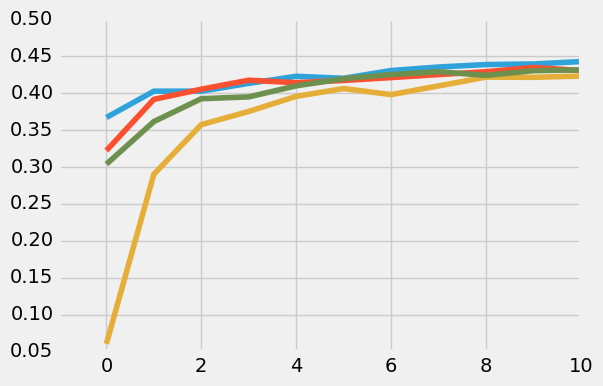

In [870]:
plt.plot(range(100),logs_rand[:,2])
plt.plot(range(100),logs_ts[:,2])
plt.plot(range(100),logs_ts[:,1])
plt.plot(range(100),logs_ts_pre[:,1])
plt.xlim(-1,10)

(-1, 10)

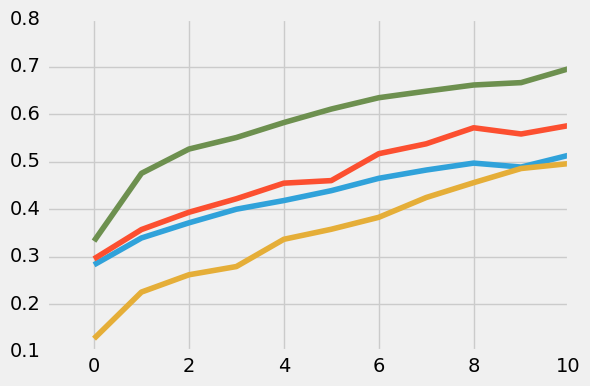

In [929]:
plt.plot(range(100),logs_rand[:,2])
plt.plot(range(100),logs_ts[:,2])
plt.plot(range(100),logs_ts[:,1])
plt.plot(range(100),logs_ts_pre[:,1])
plt.xlim(-1,10)